<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Полезные-ссылки:" data-toc-modified-id="Полезные-ссылки:-0.0.1"><span class="toc-item-num">0.0.1&nbsp;&nbsp;</span><font color="orange">Полезные ссылки:</font></a></span></li></ul></li><li><span><a href="#Общее-впечатление" data-toc-modified-id="Общее-впечатление-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span><font color="orange">Общее впечатление</font></a></span></li><li><span><a href="#Общее-впечатление-(ревью-2)" data-toc-modified-id="Общее-впечатление-(ревью-2)-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span><font color="orange">Общее впечатление (ревью 2)</font></a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Создадим-признаки-для-горизонта-прогнозирования" data-toc-modified-id="Создадим-признаки-для-горизонта-прогнозирования-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Создадим признаки для горизонта прогнозирования</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMRegressor

**Загрузим данные**

In [2]:
df = pd.read_csv('taxi.csv')

In [3]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null object
num_orders    26496 non-null int64
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


**Изменим тип данных datetime с object на datetime64 и установим индекс таблицы равным столбцу datetime.**

In [5]:
df = pd.read_csv('taxi.csv', parse_dates=[0], index_col='datetime')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


**Убедимся, что даты и время расположены в хронологическом порядке.**

In [7]:
df.index.is_monotonic

True

Выберите интервал в один час, по каждому — вычислите суммарное количество заказов.

In [8]:
df = df.resample('1H').sum()

## Анализ

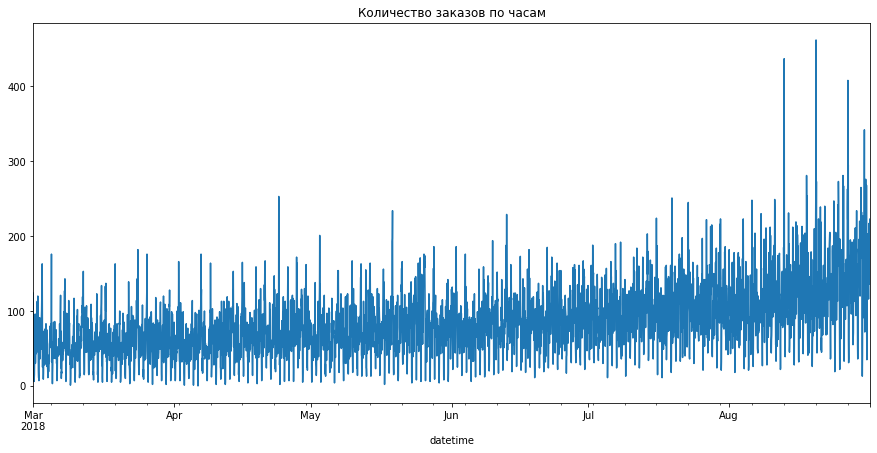

In [9]:
plt.figure(figsize=(15,7))
plt.title('Количество заказов по часам')
df['num_orders'].plot()

**Разложим временной ряд на тренд и сезонную компоненту**

In [10]:
decomposed = seasonal_decompose(df)

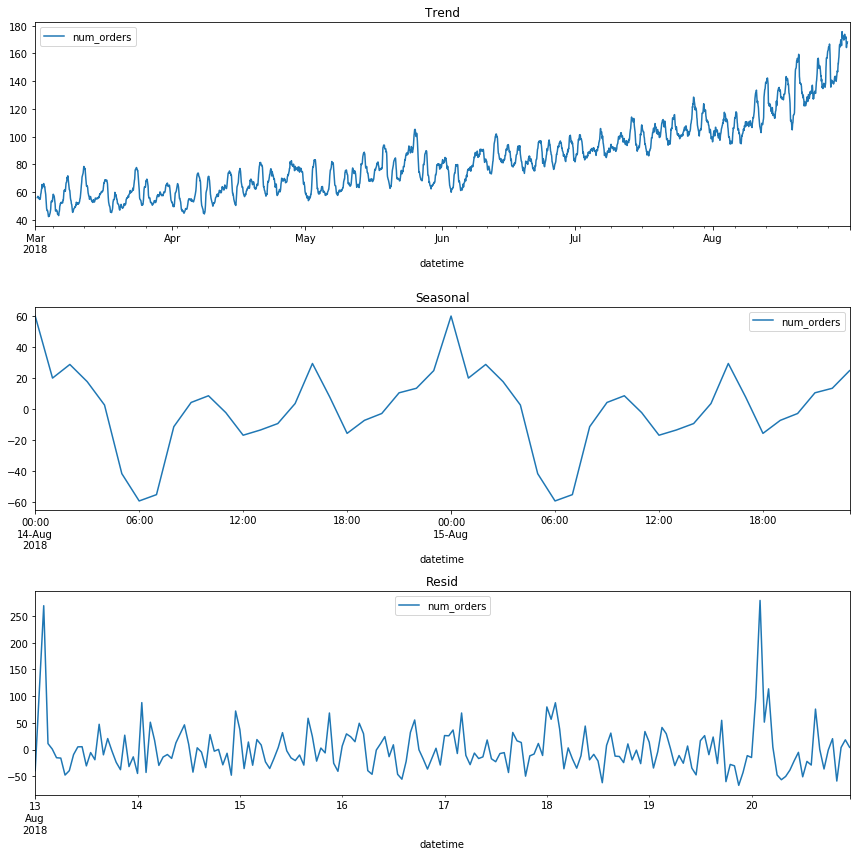

In [11]:
plt.figure(figsize=(12, 12))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)

decomposed.seasonal['2018-08-14':'2018-08-15'].plot(ax=plt.gca())
plt.title('Seasonal')

plt.subplot(313)

decomposed.resid['2018-08-13':'2018-08-20'].plot(ax=plt.gca())
plt.title('Resid')
plt.tight_layout()

Из всей выборки с марта по август можно сказать, что в летний период количество заказов растет. Это можно связять с более благоприятными температурными условиями на улице. Люди чаще отдыхают, развлекаются, ездят на дачи, шашлыки, магазины, водоемы и т.д.

Также рассмотрели сезонность по часам. В 00:06 наименьшее количество заказов, а в полночь - наибольшее. 

Временной ряд в таком виде не является стационарным, так как подвержен тренду, который меняется во времени и имеет сезонности.

## Обучение

### Создадим признаки для горизонта прогнозирования 

Напишите функцию make_features(), чтобы прибавить к таблице 2 новых календарных признака: час и день недели. 
Имена столбцов такие: 'hour', 'dayofweek'. 
Предыдущие значения временного ряда подскажут, будет ли функция x(t) расти или уменьшаться. Получим отстающие значения функцией shift(). 
В функцию make_features() добавим новый аргумент max_lag, который задаст максимальный размер отставания. Новые признаки назовем: 'lag_1', 'lag_2' — и до величины max_lag. 
Вычислим скользящее среднее и добавим его как признак 'rolling_mean'. В функцию make_features() добавим новый аргумент rolling_mean_size, который задаст ширину окна.
Скользящее среднее как признак задаёт общий тренд временного ряда.

Чтобы ряд сделать стационарным, найдём разности его значений.
Для поиска разностей временного ряда применяется метод shift(). Все значения он сдвигает вдоль временной оси на один шаг вперёд.

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

<div class="alert alert-block alert-info">
<b>Совет: </b> Желательно было написать функцию таким образом, чтобы она возвращала новый датафрейм, а не изменяла глобальную переменную.
</div>

In [13]:
make_features(df,23,26)

**LinearRegression**

In [14]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']
        
model = LinearRegression().fit(features_train,target_train)
predict_test = model.predict(features_test)
        
RMSE_line_test=np.sqrt(mean_squared_error(predict_test,target_test))

predict_train = model.predict(features_train)
        
RMSE_line_train=np.sqrt(mean_squared_error(predict_train,target_train))

In [15]:
RMSE_line_test

44.944531879585305

In [16]:
RMSE_line_train

27.41492048408175

**Catboost**

Подберем параметры для модели Catboost

In [17]:
train_pool = Pool(features_train, target_train)
test_pool = Pool(features_test, target_test)

In [18]:
modelCat = CatBoostRegressor(iterations=200)

In [19]:
grid = {
    'depth' : [5,6,7,8,9,10], 
    'learning_rate' : [0.1,0.3,0.4]
}

In [25]:
tscv = TimeSeriesSplit(n_splits=5)
result = modelCat.grid_search(grid, train_pool, cv=tscv, verbose=True)

0:	learn: 72.7335690	test: 107.7663169	best: 107.7663169 (0)	total: 294ms	remaining: 58.5s
1:	learn: 66.9406397	test: 101.4909575	best: 101.4909575 (1)	total: 299ms	remaining: 29.6s
2:	learn: 61.5617935	test: 95.2583548	best: 95.2583548 (2)	total: 309ms	remaining: 20.3s
3:	learn: 56.8820133	test: 89.0960024	best: 89.0960024 (3)	total: 320ms	remaining: 15.7s
4:	learn: 52.7022622	test: 84.4204342	best: 84.4204342 (4)	total: 328ms	remaining: 12.8s
5:	learn: 48.9878574	test: 79.8207579	best: 79.8207579 (5)	total: 336ms	remaining: 10.9s
6:	learn: 45.8268579	test: 75.9794199	best: 75.9794199 (6)	total: 341ms	remaining: 9.39s
7:	learn: 42.9860406	test: 72.5347499	best: 72.5347499 (7)	total: 348ms	remaining: 8.36s
8:	learn: 40.3677508	test: 69.1547449	best: 69.1547449 (8)	total: 351ms	remaining: 7.45s
9:	learn: 38.0114629	test: 65.8007142	best: 65.8007142 (9)	total: 358ms	remaining: 6.79s
10:	learn: 36.0291476	test: 62.7641455	best: 62.7641455 (10)	total: 366ms	remaining: 6.3s
11:	learn: 34.43

In [26]:
result['params']

{'depth': 5, 'learning_rate': 0.1}

Обучим модель на подобраных параметрах

In [27]:
%%time
model_CBR = CatBoostRegressor(
    depth=5,
    iterations=200,
    learning_rate=0.1,
    early_stopping_rounds=20
)

model_CBR.fit(
    train_pool,
    eval_set=test_pool,
    verbose=True
)

print('Model is fitted: {}'.format(model_CBR.is_fitted()))
print('Model params:\n{}'.format(model_CBR.get_params()))

0:	learn: 37.0297973	test: 82.4445587	best: 82.4445587 (0)	total: 24.8ms	remaining: 4.94s
1:	learn: 35.8304976	test: 80.0636257	best: 80.0636257 (1)	total: 30.1ms	remaining: 2.98s
2:	learn: 34.4651143	test: 78.1348318	best: 78.1348318 (2)	total: 34.5ms	remaining: 2.26s
3:	learn: 33.5244129	test: 75.7962389	best: 75.7962389 (3)	total: 39.5ms	remaining: 1.94s
4:	learn: 32.5223294	test: 73.9875314	best: 73.9875314 (4)	total: 44.1ms	remaining: 1.72s
5:	learn: 31.7051961	test: 72.5957457	best: 72.5957457 (5)	total: 47.9ms	remaining: 1.55s
6:	learn: 31.0892909	test: 71.2926381	best: 71.2926381 (6)	total: 51.5ms	remaining: 1.42s
7:	learn: 30.4201923	test: 70.0734164	best: 70.0734164 (7)	total: 54.4ms	remaining: 1.31s
8:	learn: 29.6234820	test: 68.8481818	best: 68.8481818 (8)	total: 58.4ms	remaining: 1.24s
9:	learn: 29.0846503	test: 67.6682571	best: 67.6682571 (9)	total: 62.1ms	remaining: 1.18s
10:	learn: 28.5062961	test: 66.5474309	best: 66.5474309 (10)	total: 65.9ms	remaining: 1.13s
11:	lear

In [28]:
model_CBR.get_best_score()

{'learn': {'RMSE': 17.666627946160745},
 'validation': {'RMSE': 43.514496098831515}}

In [29]:
model_CBR.get_best_score()['validation']['RMSE']

43.514496098831515

**RandomForest**

In [30]:
%%time
RF = RandomForestRegressor(criterion = "mse", n_estimators = 200)
RF.fit(features_train, target_train)
RF_pred = RF.predict(features_test)
RMSE_RF = mean_squared_error(target_test, RF_pred)**(.5)
print("RMSE RandomForest:", RMSE_RF)

RMSE RandomForest: 44.06596725968549
Wall time: 10.6 s


## Тестирование

In [31]:
data_rmse = np.array([RMSE_RF, RMSE_line_test, model_CBR.get_best_score()['validation']['RMSE']])

In [32]:
df_result=pd.DataFrame((data_rmse),index=['RandomForestRegressor', 'LinearRegression','CatBoostRegressor'])
df_result.set_axis(['RMSE'],axis='columns',inplace=True)
df_result

,RMSE
RandomForestRegressor,44.065967
LinearRegression,44.944532
CatBoostRegressor,43.514496


**Вывод**

Мы провели анализ и подготовили данные для моделей. Обучили разные модели. Путем проверки обученных моделей на тестовых выборках, пришли к выводу, что модель CatBoostRegressor дает лучшие показатели RMSE.